# Clustering Spotify Songs

The dataset contains audio_features data to different types of songs. All songs were extracted using Spotify API. 
features:

Acousticness - The higher the value the more acoustic the song is.	
Danceability - The higher the value, the easier it is to dance to this song.	
Energy - The energy of a song - the higher the value, the more energtic. song	
Instrumentalness - The higher the value the greater likelihood the song contains no vocals.	
Liveness - The higher the value, the more likely the song is a live recording.	
Loudness (dB) - The higher the value, the louder the song.	
Speechiness - The higher the value the more spoken word the song contains.	
Valence - The higher the value, the more positive mood for the song.


The Objective here is to cluster the songs and understand which genres they belong to.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hcd
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [3]:
import hdbscan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
class DataProcessing:
    def __init__(self, file):
        '''creates train and test dataframe'''
        self.df = self._load_data(file)
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def dataset_info(self, file):
        '''prints main information'''
        df = self._load_data(file)
        print('\n{0:*^80}'.format(' Reading from the file {0} '.format(file)))
        print("\nit has {0} rows and {1} columns".format(*df.shape))
        print('\n{0:*^80}\n'.format(' It has the following columns '))
        print(df.columns)
        print('\n{0:*^80}\n'.format(' Description of quantitative columns'))
        print(df.describe(include=[np.number]))
        print('\n{0:*^80}\n'.format(' Description of categorical columns'))
        print(df.describe(include=['O']))
        
    def clean_data(self, df, columns_to_drop):
        '''removes columns'''
        df = df.drop(columns_to_drop, axis=1)
        return df
    
    def standard_scaler(self, df):
        # scale df using standard scalar
        scaled = StandardScaler().fit_transform(df)
        df_scaled = pd.DataFrame(scaled, columns=df.columns)
        return df_scaled

In [94]:
class Clustering:
    def k_means(self, df, n_clusters):
        '''predict clusters using kmeans'''
        cluster = KMeans(n_clusters=n_clusters)
        df["cluster"] = cluster.fit_predict(df[df.columns])
        return df
    
    def agglomerative_clustering(self, df, n_clusters, affinity, linkage):
        '''predict clusters using hierarchical clustering'''
        hc = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        df['cluster'] = hc.fit_predict(df)
        return df
    
    def density_based_clustering(self, df, eps, metric, min_samples):
        '''predict clusters using dbscan'''
        dbscan_df = DBSCAN(eps=eps, metric=metric, min_samples=min_samples).fit(df)
        labels = dbscan_df.labels_
        df["cluster"] = dbscan_df.fit_predict(df)                                                              
        return df
    
    def hierarchical_density_based_clustering(self, df, min_cluster_size, gen_min_span_tree=True):
        '''predict clusters using hdbscan'''
        clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=gen_min_span_tree)
        clusterer_hdbscan.fit(df)
        df["cluster"] = clusterer_hdbscan.fit_predict(df) 
        return df

In [6]:
class DimentionReduction:
    def pca_transform(self, df_scaled, n_components):
        '''dimentionality reduction using pca'''
        pca = PCA(n_components=n_components)
        pcomponents = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data = pcomponents, columns = ['PC1', 'PC2'])
        ratio = pca.explained_variance_ratio_
        return pca_df, ratio
        
    def tsne_transform(self, df, n_components):
        '''dimentionality reduction using tsne'''
        tsne = TSNE(n_components=n_components).fit_transform(df)
        return tsne

In [7]:
class Visualization:
    def __init__(self):
        sns.set(rc={'figure.figsize': (11.7, 6.27)})
        self.palette = "viridis"
        self.color = "darkblue"
        
    def plot_elbow_curve(self, df, num):
        '''plot elbow curve to choose number of clusters'''
        k = range(1, num)
        kmeans = [KMeans(n_clusters=i) for i in k]
        score = [kmeans[i].fit(df[df.columns]).score(df[df.columns]) for i in range(len(kmeans))]
        pl.plot(k, score)
        pl.xlabel('Number of Clusters')
        pl.ylabel('Score')
        pl.title('Elbow Curve')
        pl.show()
        
    def plot_pca(self, pca_df, df, cluster_column):
        '''scatterplot to visualize after pca transformation'''
        sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First principle component')
        plt.ylabel('Second principle component')
        plt.show()
        
    def plot_tsne(self, tsne_df, df, cluster_column):
        '''scatterplot to visualize after tsne transformation'''
        sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First tsne component')
        plt.ylabel('Second tsne component')
        plt.show()
        
    def plot_dendrogram(self, df, metric, method):
        '''plot dendrogram to choose number of clusters'''
        plt.style.use('ggplot')
        hcd.set_link_color_palette(["#B061FF", "#7a0177"])
        dendrogram = hcd.dendrogram(hcd.linkage(df, metric=metric, method=method))
        plt.title('Dendrogram', size=20)
        plt.xlabel('Customers', size=15)
        plt.ylabel('Euclidean Distances', size=15)
        plt.show()
        
    def plot_clusters(self, df, cluster):
        '''plot clusters interpretation'''
        sns.set_style("whitegrid")
        bins = np.linspace(0,1,10)
        fig, ax = plt.subplots(1, 6, figsize=(15, 3))
        cluster_df = df[df.cluster == cluster]
        cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness', 'tempo']
        col = 0
        for feature in cluster_features:
            general = df.groupby(pd.cut(df[feature], bins)).size().reset_index(name='count')
            cluster = cluster_df.groupby(pd.cut(cluster_df[feature], bins)).size().reset_index(name='count')
            sns.barplot(data=general, x=feature, y='count', color='#efedf5', ax=ax[col])
            sns.barplot(data=cluster, x=feature, y='count', color='#54278f', ax=ax[col])
            ax[col].set_xticklabels(range(1,10), fontsize=12)
            col += 1
        plt.show()    

In [8]:
file = "./data/songs.csv"

In [9]:
data = DataProcessing(file)
df = data.df
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.994,0.335,0.00532,0.912,0.0621,-31.646,0.0376,65.832,0.0397
1,0.993,0.343,0.02520,0.932,0.0454,-27.013,0.0488,67.207,0.0395
2,0.994,0.242,0.00898,0.909,0.0814,-31.811,0.0424,68.880,0.0549
3,0.993,0.367,0.01900,0.914,0.0698,-28.121,0.0542,169.443,0.0391
4,0.992,0.295,0.06730,0.868,0.0721,-24.793,0.0362,71.254,0.0801


In [10]:
df.shape

(6171, 9)

In [95]:
clustering = Clustering()
dimention = DimentionReduction()
plot = Visualization()

In [12]:
scaled_df = data.standard_scaler(df)

# KMeans Clustering


Cluster size 8 looks most reasonable based on the Elbow Curve


1. Use Scaled dataset
2. Elbow_curve
3. K-Means with n_clusters
4. PCA visualize
5. TSNE visualize

## Plot Elbow Curve

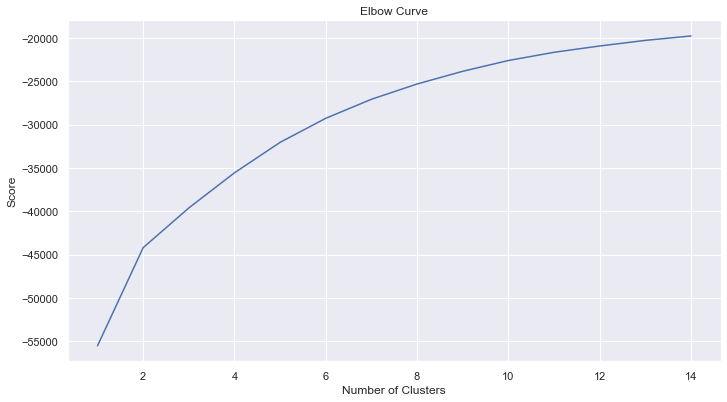

In [13]:
plot.plot_elbow_curve(scaled_df, 15)

## Create 8 Clusters

In [14]:
kmeans_df = clustering.k_means(scaled_df, 8)

In [80]:
kmeans_df.groupby([kmeans_df.cluster == 7]).size()

cluster
False    5328
True      843
dtype: int64

## Visualization using PCA (K-Means)

In [15]:
kmeans_df_transform, ratio = dimention.pca_transform(kmeans_df, 2)

In [16]:
# explained_variance_ratio
ratio

array([0.49252014, 0.16880058])

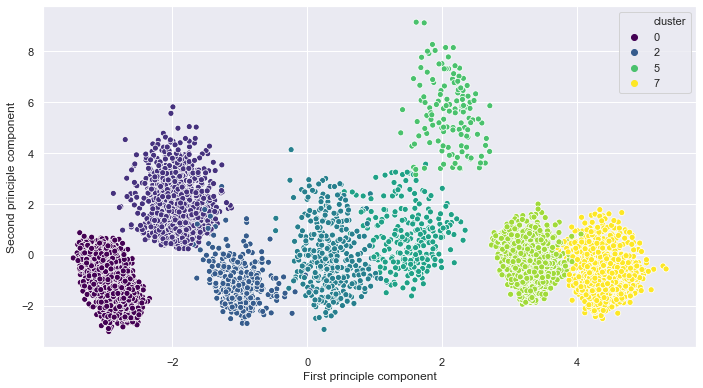

In [17]:
plot.plot_pca(kmeans_df_transform, kmeans_df, 'cluster')

## Visualization using TSNE (K-Means)

In [18]:
kmeans_tsne = dimention.tsne_transform(kmeans_df, 2)

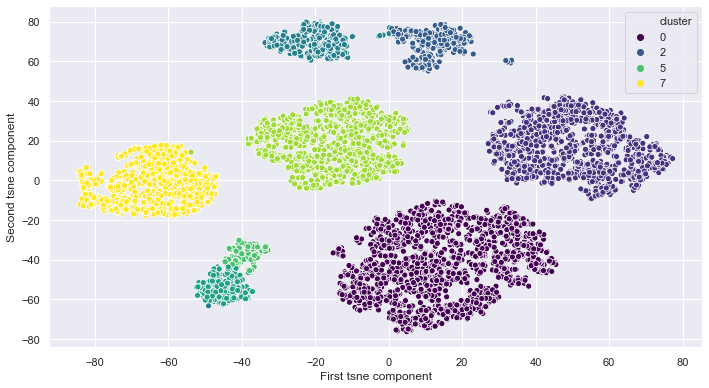

In [19]:
plot.plot_tsne(kmeans_tsne, kmeans_df, 'cluster')

## Visualization segments

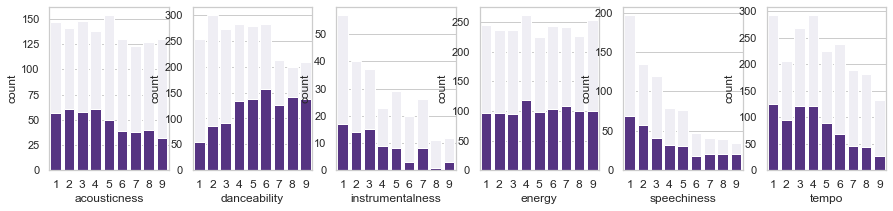

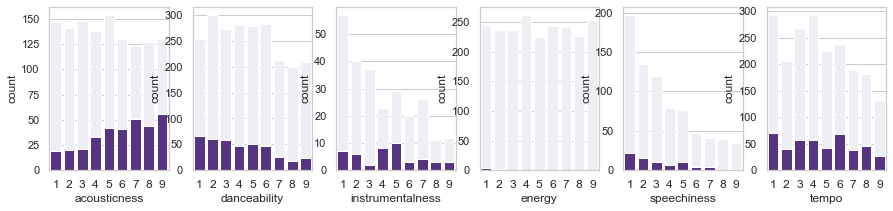

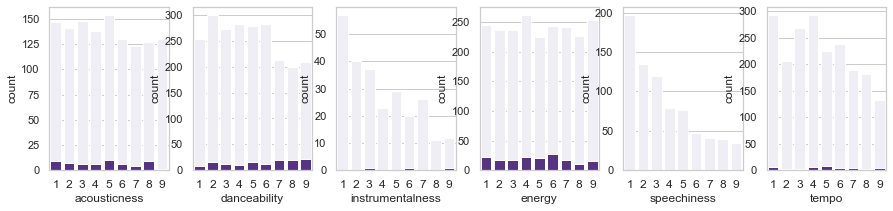

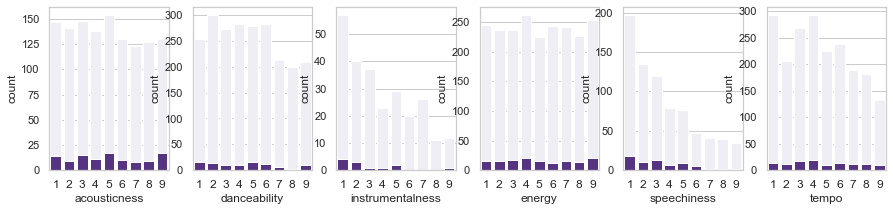

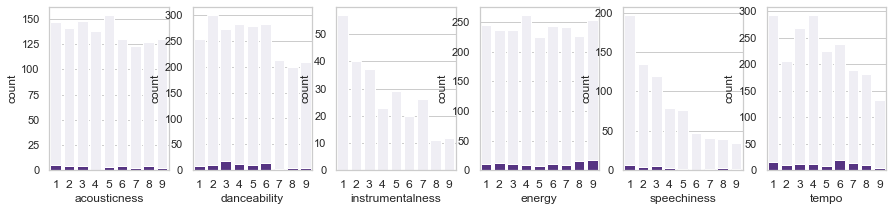

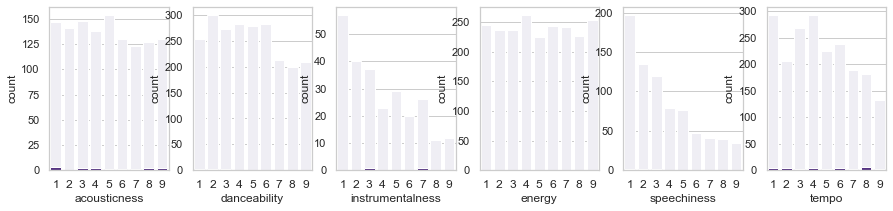

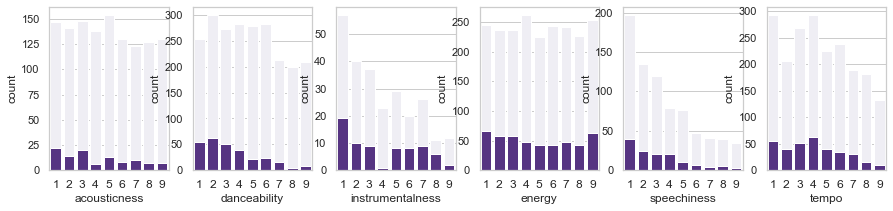

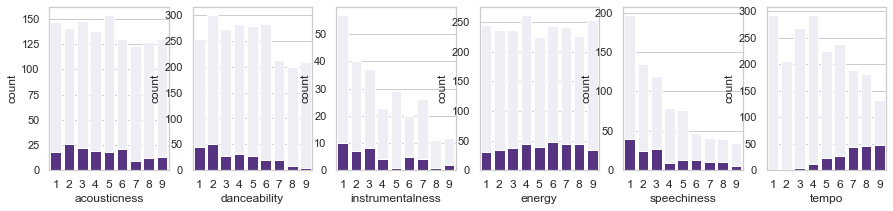

In [20]:
for i in np.sort(kmeans_df['cluster'].unique()):
    plot.plot_clusters(kmeans_df, i)

Cluster 1 HIGH: danceability, energy; LOW: instrumentalness, tempo

Cluster 2 HIGH: acousticness, tempo;  LOW: energy, danceability

Cluster 3 energy danceability

Cluster 4

Cluster 5

Cluster 6

Cluster 7 HIGH: energy;  LOW: speechiness, danceability

Cluster 8 HIGH: energy, tempo;  LOW: instrumentalness, danceability, speechiness

# Hierarchical Clustering
## Dendogram - Finding Optimal Number of Clusters

Cluster size 8 looks most reasonable based on the Dendogram.

1. Use Scaled dataset
2. Dendrogram
3. Agglomerative Clustering
4. PCA visualize
5. TSNE visualize

In [23]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,2.389082,-1.578245,-2.748012,4.492992,-0.779126,-5.635764,-0.376899,-1.829055,-2.042643
1,2.385671,-1.528525,-2.660396,4.598303,-0.870927,-4.503172,-0.255269,-1.781920,-2.043417
2,2.389082,-2.156243,-2.731881,4.477196,-0.673033,-5.676100,-0.324772,-1.724571,-1.983831
3,2.385671,-1.379364,-2.687721,4.503523,-0.736798,-4.774036,-0.196626,1.722682,-2.044964
4,2.382261,-1.826846,-2.474850,4.261309,-0.724155,-3.960467,-0.392103,-1.643191,-1.886327


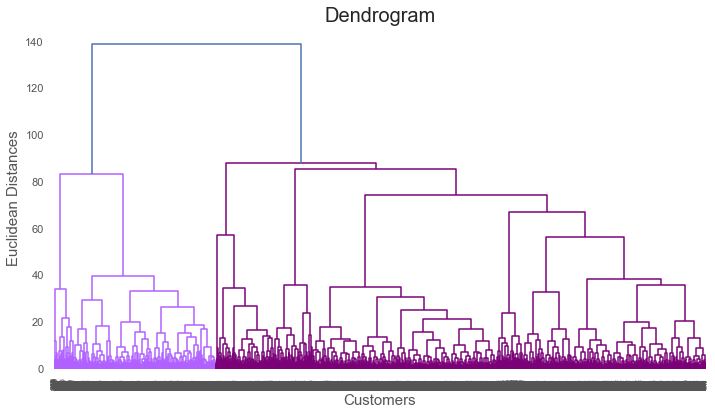

In [24]:
plot.plot_dendrogram(scaled_df, 'euclidean', 'ward')

In [25]:
hc_df = clustering.agglomerative_clustering(scaled_df, 8, 'euclidean', 'ward')

In [26]:
hc_df.cluster.unique()

array([4, 2, 0, 6, 3, 1, 5, 7])

##  Visualization using PCA (Hierarchical Clustering)

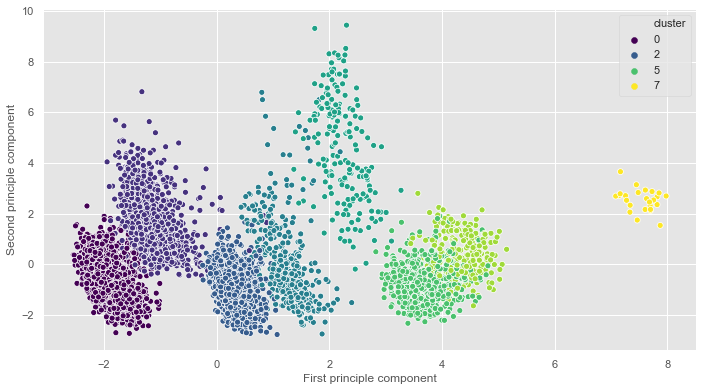

In [27]:
hc_df_transform, ratio = dimention.pca_transform(hc_df, 2)
plot.plot_pca(hc_df_transform, hc_df, 'cluster')

In [28]:
ratio

array([0.30884931, 0.23179648])

## Visualization using TSNE (Hierarchical Clustering)

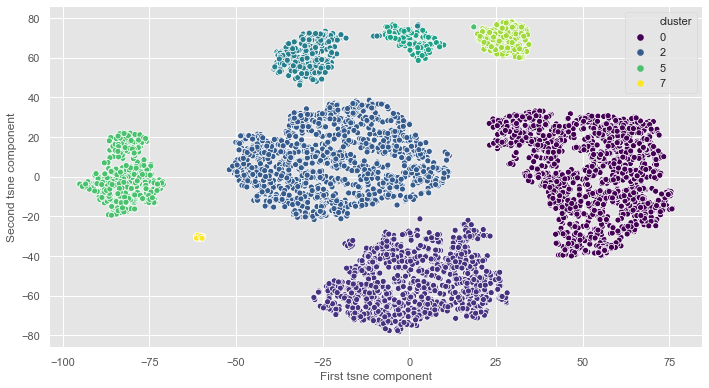

In [29]:
hc_tsne = dimention.tsne_transform(hc_df, 2)
plot.plot_tsne(hc_tsne, hc_df, 'cluster')

## Visualization segments

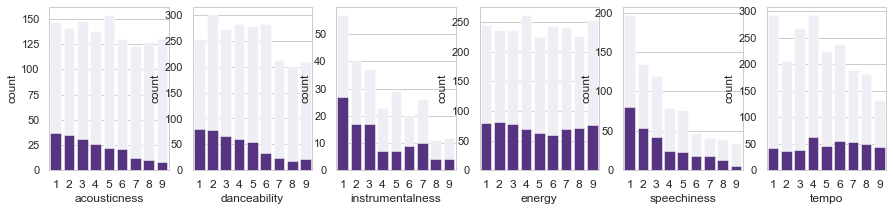

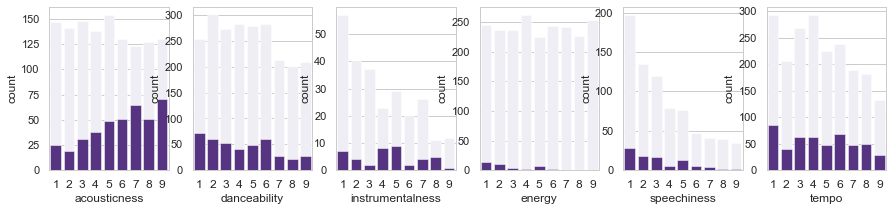

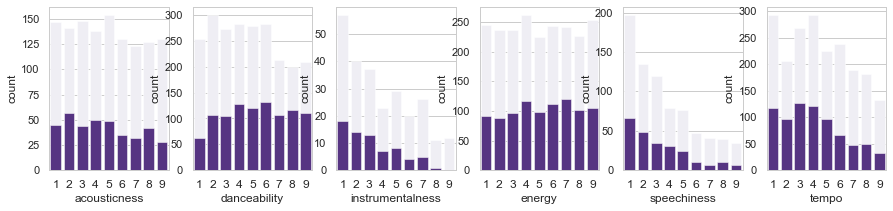

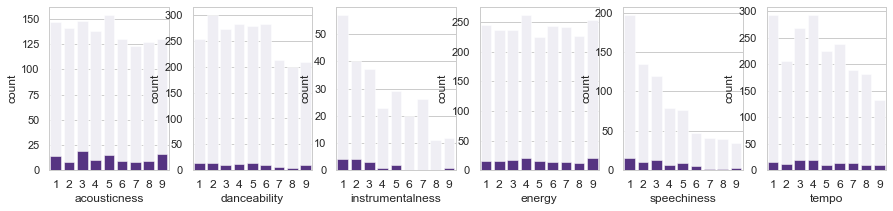

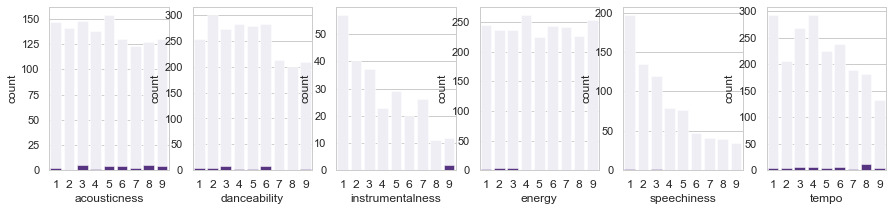

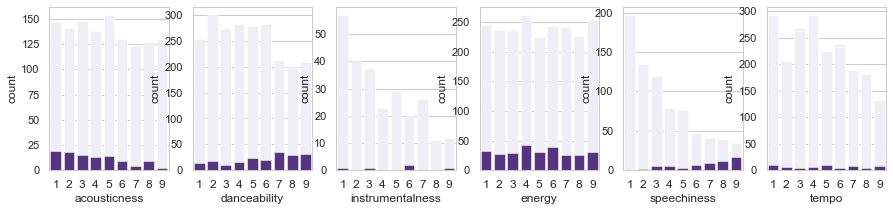

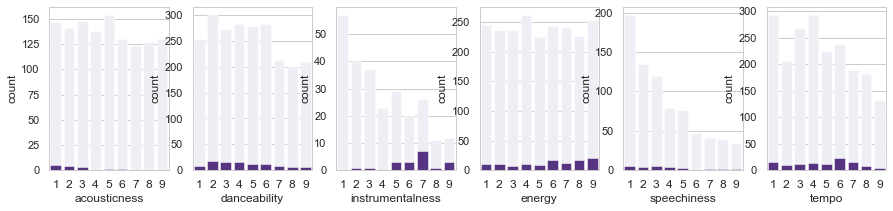

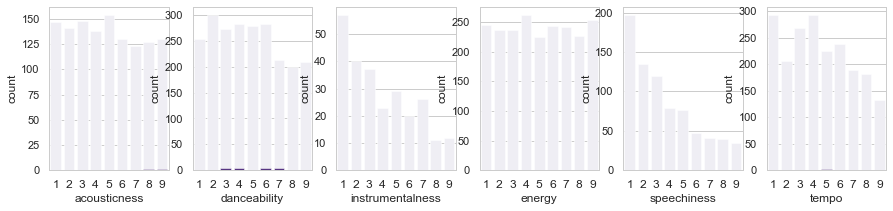

In [30]:
for i in np.sort(hc_df['cluster'].unique()):
    plot.plot_clusters(hc_df, i)

Cluster 1 HIGH: energy; LOW: instrumentalness, speechiness

Cluster 2 HIGH: acousticness, tempo; LOW: energy, danceability

Cluster 3 HIGH: energy, danceability; LOW: instrumentalness, speechiness

Cluster 4 energy

Cluster 5

Cluster 6 energy

Cluster 7 instrumentalness, energy

Cluster 8 

# DBSCAN

1. Use Scaled dataset
2. Density Based Clustering with parameters eps and min
3. PCA visualize
4. TSNE visualize

In [32]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,2.389082,-1.578245,-2.748012,4.492992,-0.779126,-5.635764,-0.376899,-1.829055,-2.042643
1,2.385671,-1.528525,-2.660396,4.598303,-0.870927,-4.503172,-0.255269,-1.781920,-2.043417
2,2.389082,-2.156243,-2.731881,4.477196,-0.673033,-5.676100,-0.324772,-1.724571,-1.983831
3,2.385671,-1.379364,-2.687721,4.503523,-0.736798,-4.774036,-0.196626,1.722682,-2.044964
4,2.382261,-1.826846,-2.474850,4.261309,-0.724155,-3.960467,-0.392103,-1.643191,-1.886327


In [43]:
density_df = clustering.density_based_clustering(scaled_df, 0.5, 'euclidean', 6)

In [44]:
density_df.cluster.unique()

array([-1,  1,  5,  3,  0,  4,  2,  6])

## Visualization using TSNE (DBSCAN)

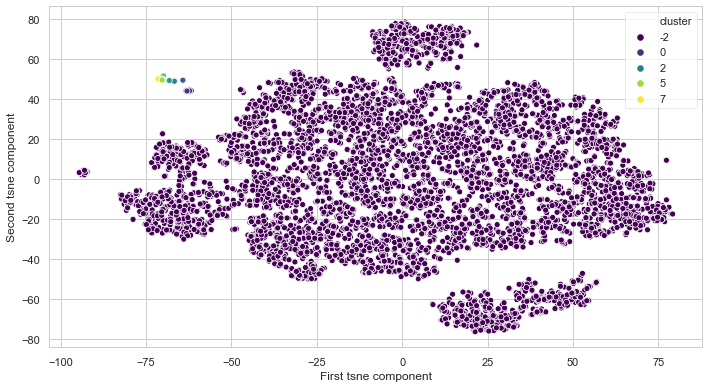

In [45]:
density_tsne = dimention.tsne_transform(density_df, 2)
plot.plot_tsne(density_tsne, density_df, 'cluster')

## Visualization using PCA (DBSCAN)

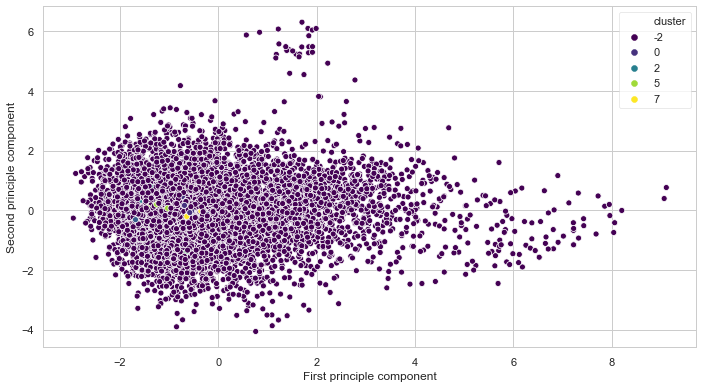

In [46]:
#density_df_scaled = data.standard_scaler(density_df)
density_df_transform, ratio = dimention.pca_transform(density_df, 2)
plot.plot_pca(density_df_transform, density_df, 'cluster')

In [47]:
ratio

array([0.30443238, 0.15314379])

## Visualization segments

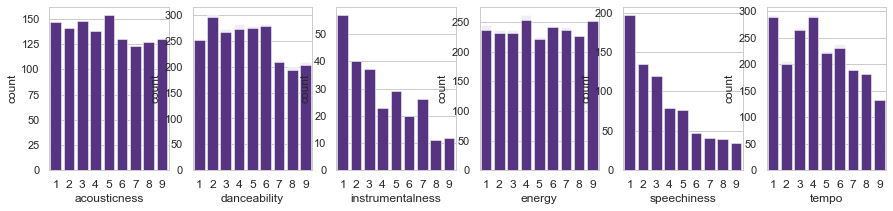

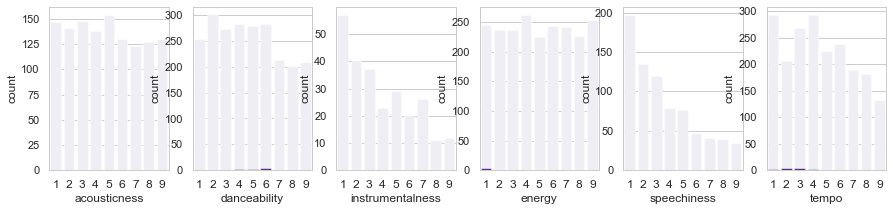

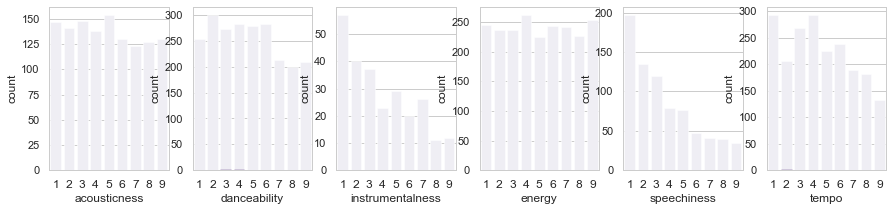

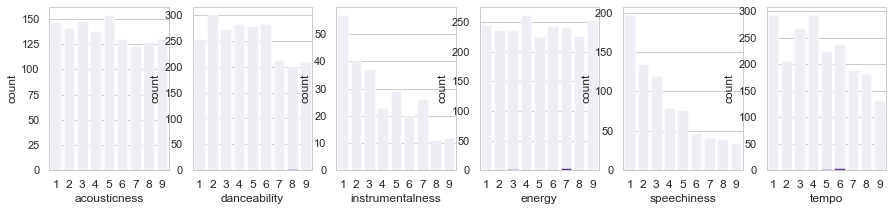

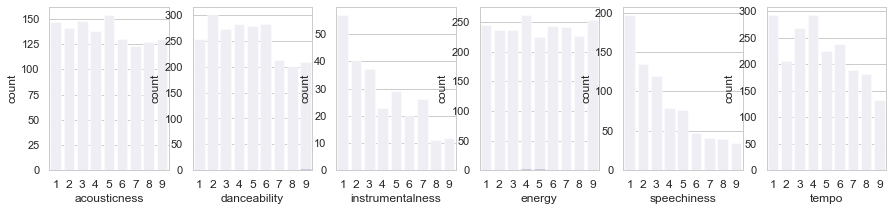

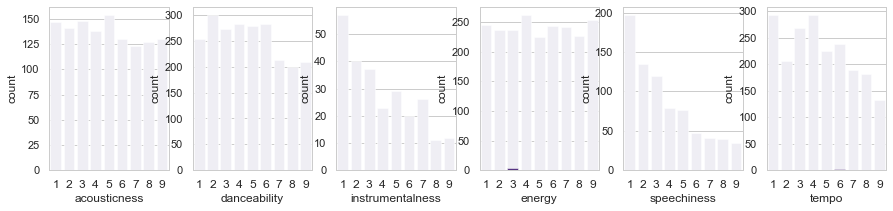

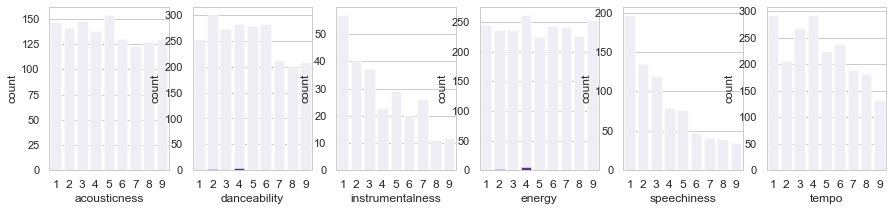

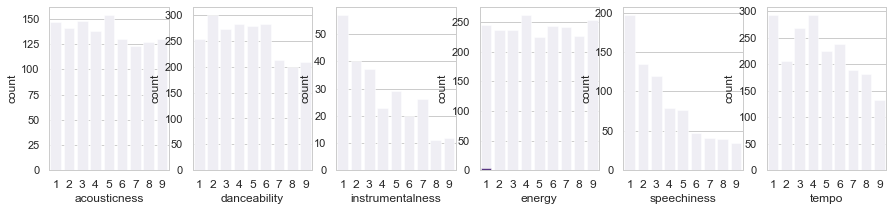

In [48]:
for i in np.sort(density_df['cluster'].unique()):
    plot.plot_clusters(density_df, i)

# HDBSCAN

1. Use Scaled dataset
2. Hierarchical Density-Based Clustering with parameter min_cluster_size
3. PCA visualize
4. TSNE visualiz

In [101]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,2.389082,-1.578245,-2.748012,4.492992,-0.779126,-5.635764,-0.376899,-1.829055,-2.042643
1,2.385671,-1.528525,-2.660396,4.598303,-0.870927,-4.503172,-0.255269,-1.781920,-2.043417
2,2.389082,-2.156243,-2.731881,4.477196,-0.673033,-5.676100,-0.324772,-1.724571,-1.983831
3,2.385671,-1.379364,-2.687721,4.503523,-0.736798,-4.774036,-0.196626,1.722682,-2.044964
4,2.382261,-1.826846,-2.474850,4.261309,-0.724155,-3.960467,-0.392103,-1.643191,-1.886327


In [102]:
hdbscan_df = clustering.hierarchical_density_based_clustering(scaled_df, 20, gen_min_span_tree=False)

In [103]:
hdbscan_df.cluster.unique()

array([-1,  1,  2,  0])

In [104]:
hdbscan_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cluster
0,2.389082,-1.578245,-2.748012,4.492992,-0.779126,-5.635764,-0.376899,-1.829055,-2.042643,-1
1,2.385671,-1.528525,-2.660396,4.598303,-0.870927,-4.503172,-0.255269,-1.781920,-2.043417,1
2,2.389082,-2.156243,-2.731881,4.477196,-0.673033,-5.676100,-0.324772,-1.724571,-1.983831,-1
3,2.385671,-1.379364,-2.687721,4.503523,-0.736798,-4.774036,-0.196626,1.722682,-2.044964,-1
4,2.382261,-1.826846,-2.474850,4.261309,-0.724155,-3.960467,-0.392103,-1.643191,-1.886327,1


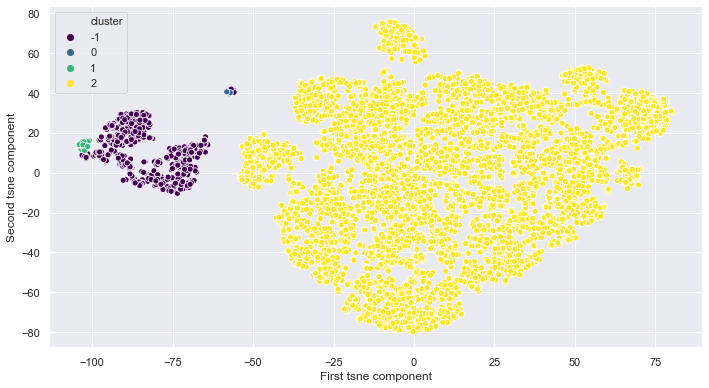

In [105]:
hdbscan_tsne = dimention.tsne_transform(hdbscan_df, 2)
plot.plot_tsne(hdbscan_tsne, hdbscan_df, 'cluster')

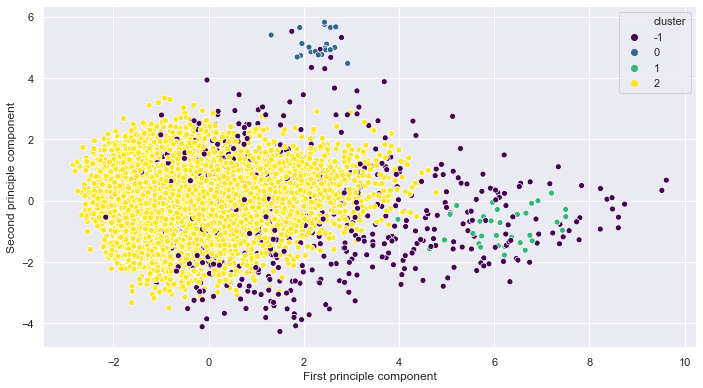

In [106]:
hdbscan_df_transform, ratio = dimention.pca_transform(hdbscan_df, 2)
plot.plot_pca(hdbscan_df_transform, hdbscan_df, 'cluster')

## Visualization segments

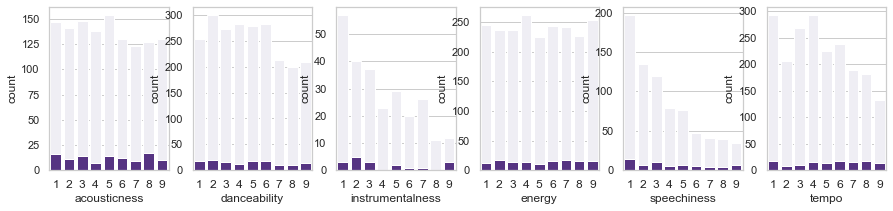

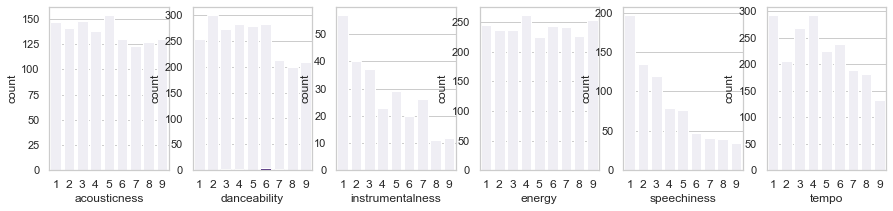

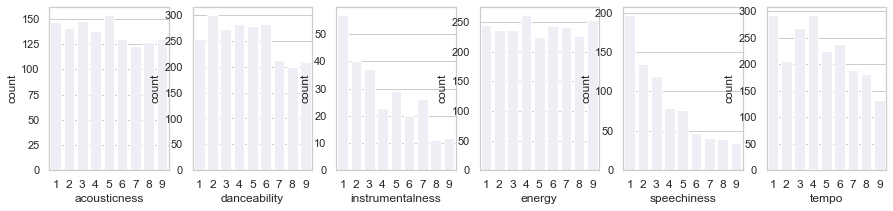

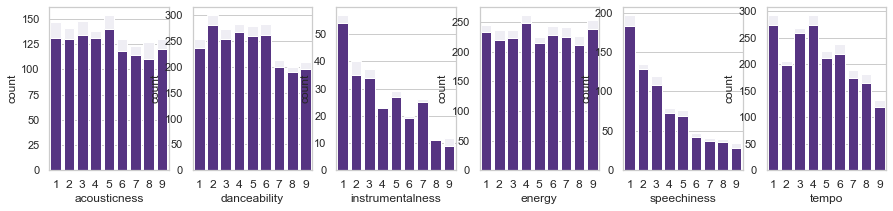

In [107]:
for i in np.sort(hdbscan_df['cluster'].unique()):
    plot.plot_clusters(hdbscan_df, i)

kmeans_df, hdbscan_df, dbscan_df, hc_df